# Modelling camera trapping data with NN in python


Run this notebook in colab: https://colab.research.google.com/drive/1eL88mj3O2YREdr6-y6AnVO4nYM7fso7h?usp=sharing

### Mounting my Google drive

We have to tell our *virtual computer* where is the data we are going to be working with, so we need to give it permissions to connect to our Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/NN_WORKSHOP_DATA


1.Resize_images.ipynb		     models	  y_train.npy
2.CNN_in_Python.ipynb		     X_test.npy
3.Transfer_learning_in_Python.ipynb  X_train.npy


In [ ]:
import os
os.chdir('/content/drive/MyDrive/NN_WORKSHOP_DATA')

### Imports

Here we import all the modules that we are going to need. This is similar to `library('package_name')` in R

In [ ]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from tensorflow.keras.utils import to_categorical
from keras.callbacks import Callback
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

### Data loading

Load the resized images from our Drive

In [ ]:
# The data, split between train and test sets:
x_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')


x_train shape: (196299, 32, 32, 3)
196299 train samples


### Data preprocessing and split


In [ ]:
# Convert the images to float and scale it to a range of 0 to 1
x_train = x_train.astype('float32')
x_train /= 255.


In [ ]:
# Split the data in Train, Test, and Validation
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size= 0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size= 0.3, random_state=42)

### Define model and model architecture

In [ ]:
batch_size = 64
num_classes = 14
epochs = 30
val_split = 0.1
save_dir = os.path.join(os.getcwd(), 'models')
model_name = 'keras_cnn_model.h5'

In [ ]:
#Define model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        1

In [ ]:
class Metrics(Callback):
    def __init__(self, val_data):
        super().__init__()
        self.validation_data = val_data
        
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        y_pred_cat = to_categorical(
            y_pred.argmax(axis=1),
            num_classes=num_classes
        )

        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return

![image.png](https://www.biorxiv.org/sites/default/files/highwire/biorxiv/early/2017/01/04/087445/embed/graphic-10.gif)

In [ ]:
f1_metrics = Metrics(val_data= (X_val, y_val))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

hist = model.fit(
    X_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[f1_metrics],
    validation_data=(X_val, y_val),
    shuffle=True
)


Epoch 1/30
2148/2148 [==============================] - 32s 14ms/step - loss: 0.4872 - accuracy: 0.8413 - val_loss: 0.4121 - val_accuracy: 0.8668
val_f1: 0.6560 — val_precision: 0.7017 — val_recall: 0.6335
Epoch 2/30
2148/2148 [==============================] - 30s 14ms/step - loss: 0.4362 - accuracy: 0.8554 - val_loss: 0.3699 - val_accuracy: 0.8755
val_f1: 0.6923 — val_precision: 0.7438 — val_recall: 0.6634
Epoch 3/30
2148/2148 [==============================] - 31s 14ms/step - loss: 0.4038 - accuracy: 0.8669 - val_loss: 0.3673 - val_accuracy: 0.8807
val_f1: 0.7073 — val_precision: 0.7356 — val_recall: 0.6928
Epoch 4/30
2148/2148 [==============================] - 31s 14ms/step - loss: 0.3896 - accuracy: 0.8717 - val_loss: 0.3347 - val_accuracy: 0.8899
val_f1: 0.7279 — val_precision: 0.7611 — val_recall: 0.7150
Epoch 5/30
2148/2148 [==============================] - 30s 14ms/step - loss: 0.3628 - accuracy: 0.8770 - val_loss: 0.3279 - val_accuracy: 0.8917
val_f1: 0.7438 — val_precision

In [ ]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)


Saved trained model at /content/drive/My Drive/NN_WORKSHOP_DATA/models/keras_cnn_model.h5 


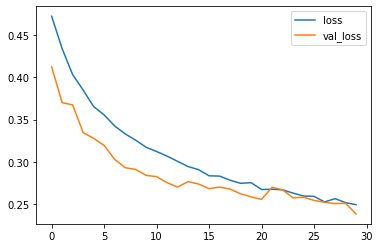

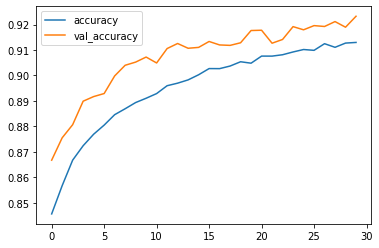

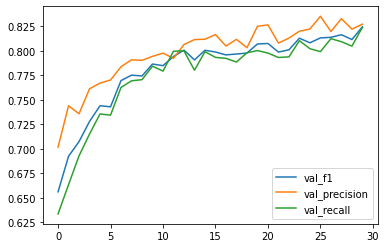

In [ ]:
history_df = pd.DataFrame(hist.history)
history_df['val_f1'] = f1_metrics.val_f1s
history_df['val_precision'] = f1_metrics.val_precisions
history_df['val_recall'] = f1_metrics.val_recalls

history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()
history_df[['val_f1', 'val_precision', 'val_recall']].plot()


### Reload model and predictions

In [ ]:
model = keras.models.load_model('models/keras_cnn_model.h5')

In [ ]:
y_pred = model.predict(X_test)


In [ ]:
y_pred

array([[1.00000000e+00, 1.05146787e-13, 1.02645157e-15, ...,
        3.92546781e-14, 1.78437371e-22, 0.00000000e+00],
       [9.99999881e-01, 2.78555484e-10, 2.06041625e-11, ...,
        1.01030136e-10, 3.05352916e-16, 0.00000000e+00],
       [1.64925128e-01, 8.34496096e-02, 2.50445941e-04, ...,
        2.51844205e-04, 1.64692141e-02, 1.41670466e-06],
       ...,
       [1.81562882e-02, 1.42762932e-04, 9.58941382e-05, ...,
        1.40276956e-04, 1.96100652e-01, 5.33008526e-14],
       [1.00000000e+00, 3.64094016e-19, 2.47879022e-18, ...,
        5.21090925e-20, 2.93810443e-26, 0.00000000e+00],
       [9.70289528e-01, 2.70125565e-05, 1.50705397e-03, ...,
        2.95811356e-03, 3.73489570e-07, 5.42400823e-17]], dtype=float32)

In [ ]:
predictions = [x.argmax() for x in y_pred]

In [ ]:
real = [x.argmax() for x in y_test]

In [ ]:
classes_wild = {0: 'empty', 1: 'deer', 2: 'moose', 3: 'squirrel', 4: 'rodent', 5: 'small_mammal', \
                6: 'elk', 7: 'pronghorn_antelope', 8: 'rabbit', 9: 'bighorn_sheep', 10: 'fox', 11: 'coyote', \
                12: 'black_bear', 13: 'raccoon', 14: 'skunk', 15: 'wolf', 16: 'bobcat', 17: 'cat',\
                18: 'dog', 19: 'opossum', 20: 'bison', 21: 'mountain_goat', 22: 'mountain_lion'}
keys = [0, 1, 3, 4, 8, 10, 11, 13, 14, 16, 17, 18, 19, 22]
labels = [classes_wild[k] for k in keys]

In [ ]:
pred = [classes_wild[x] for x in predictions]
true = [classes_wild[x] for x in real]

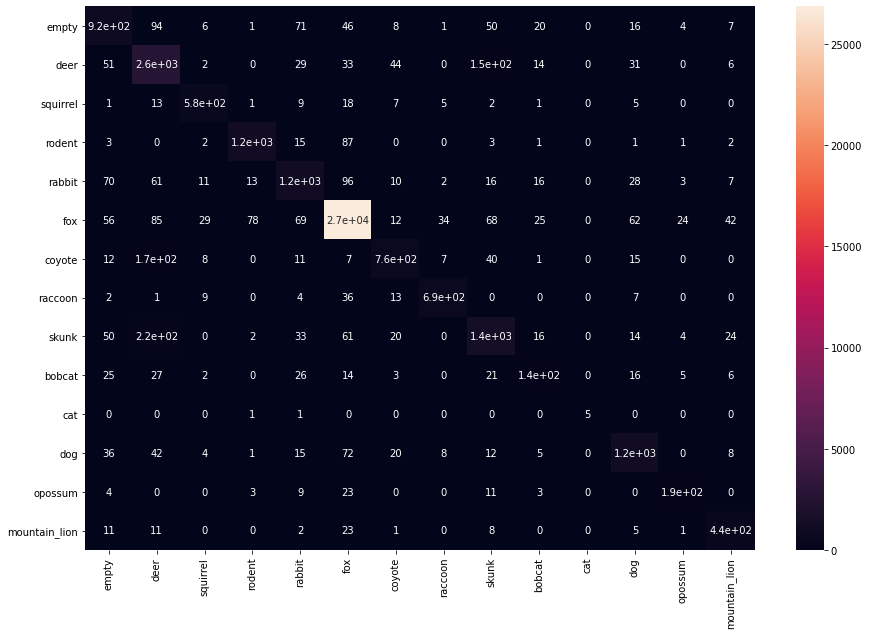

In [ ]:
f, ax = plt.subplots(figsize=(15,10))
sns.heatmap(confusion_matrix(y_true=true, y_pred=pred),xticklabels=labels, yticklabels=labels, annot=True, ax=ax)


# **TIME FOR SOME HYPERPARAMETER TUNNING!! ...**